# Freshwater content in the SPG

In [1]:
import numpy as np
import xarray as xr
import gsw

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from mpl_toolkits.basemap import Basemap

from dateutil import parser
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
def ncdatetime(month):
    basedate = parser.parse("2004-01-01")
    _dt = (basedate + relativedelta(months=int(month))).replace(day=15)
    return _dt

### Load datasets

#### Roemmich-Gilson Argo salinity

In [3]:
# Open RG monthly fields
nc = xr.open_dataset('RG_ArgoClim_Psal.nc',decode_times=False)

# Convert time
nc.TIME.values = [ncdatetime(n) for n in nc.TIME.values]

# Change longitude (-180 to 180)
nc_l = nc.sel(LONGITUDE=slice(180,380))
nc_l['LONGITUDE'] = nc_l['LONGITUDE'] - 360
nc_r = nc.sel(LONGITUDE=slice(0,180))
ds = xr.concat([nc_l,nc_r],dim='LONGITUDE')
del nc_l,nc_r

#### Area

In [4]:
# Load gridded area (convert from km^2 to m^2)
a_nc = 1000*1000*xr.open_dataset('area1x1.nc')

In [5]:
ds['AREA'] = a_nc.sel(LATITUDE=slice(-64.5,64.5)).AREA

In [6]:
ds.AREA.attrs= {'units': 'm^2','long_name': 'Grid area'}

### Set spatial and temporal range

In [7]:
south = 10
north = 70
west = -85
east = 0

tstart = '2004-01-15'
tend = '2017-10-15'

In [8]:
psal_anom = ds.ARGO_SALINITY_ANOMALY.sel(LATITUDE=slice(south,north),LONGITUDE=slice(west,east),
                                         TIME=slice(tstart,tend))

psal_mean = ds.ARGO_SALINITY_MEAN.sel(LATITUDE=slice(south,north),LONGITUDE=slice(west,east))


psal = (psal_mean + psal_anom).transpose('TIME','PRESSURE','LATITUDE','LONGITUDE')

## Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [9]:
psal_ref = 34.80

In [10]:
f = (psal_ref - psal)/psal_ref

/opt/rh/python27/root/usr/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


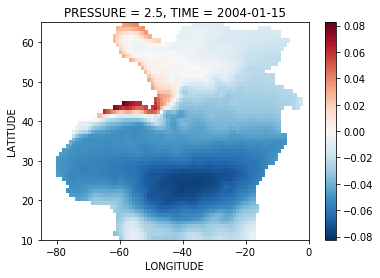

In [11]:
f[0,0].plot()

### Array of grid height (`dz`)

In [12]:
pres_bnds = ds.PRESSURE_bnds.sel(LONGITUDE=slice(west,east))

In [13]:
# Broadcast arrays
(p_lower,p_upper,lat,lon) = xr.broadcast(pres_bnds[:,:,1],pres_bnds[:,:,0],f.LATITUDE, f.LONGITUDE)

In [14]:
z_lower = gsw.z_from_p(p_lower,lat)
z_upper = gsw.z_from_p(p_upper,lat)

In [15]:
dz = xr.DataArray(z_upper-z_lower, coords=[f.LONGITUDE,f.PRESSURE,f.LATITUDE],
                  dims=['LONGITUDE','PRESSURE','LATITUDE']).transpose('PRESSURE','LATITUDE','LONGITUDE')

### Sum over depth levels

In [16]:
D = 500
print np.shape(f)
print np.shape((f * dz).sel(PRESSURE=slice(0,D)))

(166, 58, 55, 85)
(166, 34, 55, 85)


In [17]:
h_fw = (f * dz).sel(PRESSURE=slice(0,D)).sum('PRESSURE')

### Spatially integrate to obtain the liquid freshwater content (LFWC)
$$LFWC = \oint h_{fw}\; dA$$

For the subpolar gyre (SPG) we take the common spatial range of 50-62N and 10-60W

In [18]:
spg_lats = [50, 62, 62, 50]
spg_lons = [-60, -60, -10, -10]

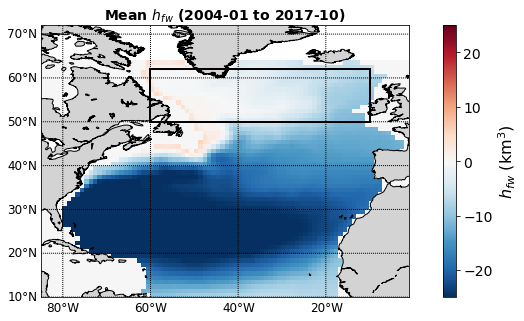

In [20]:
fig = plt.figure(figsize=(12,5))

m = Basemap(projection='cyl', llcrnrlat=south, urcrnrlat=north+2, llcrnrlon=west, urcrnrlon=east-1, 
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-60,90,10),labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(-180,180,20),labels=[0,0,0,1],fontsize=12)
p = m.pcolormesh(h_fw.LONGITUDE-0.5,h_fw.LATITUDE-0.5,np.ma.masked_invalid(h_fw.mean('TIME')),
                 cmap='RdBu_r',vmin=-25, vmax=25)

box = Polygon(zip(spg_lons, spg_lats), facecolor='none',edgecolor='black', linewidth=2)
plt.gca().add_patch(box)
plt.title('Mean $h_{fw}$ (2004-01 to 2017-10)',fontsize=14,fontweight='bold')

cb = fig.colorbar(p)
cb.set_label(r'$h_{fw}$ (km$^3$)',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()

In [21]:
h_fw_spg = h_fw.sel(LATITUDE=slice(np.min(spg_lats),np.max(spg_lats)),
                    LONGITUDE=slice(np.min(spg_lons),np.max(spg_lons)))

lfwc_spg = (h_fw_spg * ds.AREA).sum(dim=['LATITUDE','LONGITUDE'])

# Convert from m^3 to km^3
lfwc_spg = lfwc_spg*1e-9

In [22]:
lfwc_spg_anom = lfwc_spg - lfwc_spg.mean('TIME')

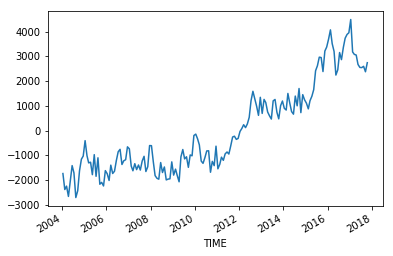

In [23]:
lfwc_spg_anom.plot()

In [24]:
lfwc_spg_initial = lfwc_spg_anom.sel(TIME=slice('2004-01-15','2005-12-15')).mean('TIME')
lfwc_spg_final = lfwc_spg_anom.sel(TIME=slice('2015-11-15','2017-10-15')).mean('TIME')
DeltaLDWC = lfwc_spg_final.values - lfwc_spg_initial.values
print np.round(DeltaLDWC)

4874.0


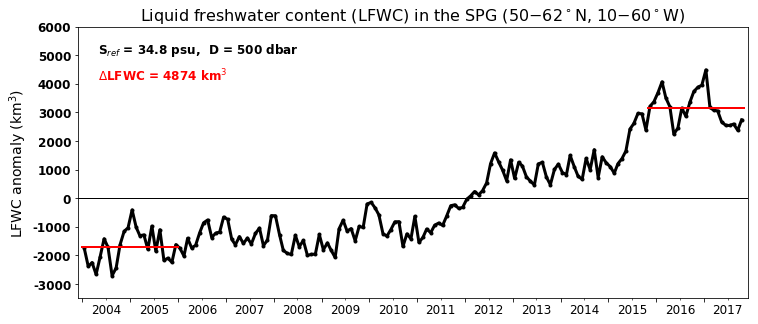

In [25]:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()

ax.plot(lfwc_spg_anom.TIME, lfwc_spg_anom, lw=3, color='k', marker='.')
ax.plot(['2004-01-01','2005-12-31'], [lfwc_spg_initial,lfwc_spg_initial], lw=2, color='r')
ax.plot(['2015-11-01','2017-10-31'], [lfwc_spg_final,lfwc_spg_final], lw=2, color='r')
ax.set_ylim([-3500,6000])
ax.set_xlim(['2003-11-30','2017-12-01'])
ax.set_yticks(np.arange(-3000,7000,1000))
ax.set_yticklabels(np.arange(-3000,7000,1000),fontsize=12,fontweight='bold')
ax.set_ylabel(r'LFWC anomaly (km$^3$)',fontsize=14)
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1, color = 'k')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(12)
#plt.text(1200,2000,'For D = 500 dbar, \Delta LFWC = %s',lfwc_spg_final.values - lfwc_spg_initial.values)
ax.text(0.03,0.90, 'S$_{ref}$ = %.1f psu,  D = %d dbar' % (psal_ref,D),
        transform=ax.transAxes, fontsize=12, fontweight='bold')
ax.text(0.03,0.80, r'$\Delta$LFWC = %d km$^3$' % np.round(DeltaLDWC), 
        transform=ax.transAxes, fontsize=12, fontweight='bold',color='r')
ax.set_title(r'Liquid freshwater content (LFWC) in the SPG (50$-$62$^\circ$N, 10$-$60$^\circ$W)',fontsize=16)

plt.savefig('/tmp/figure.png')
#plt.savefig('/tmp/figure.eps')
plt.show()

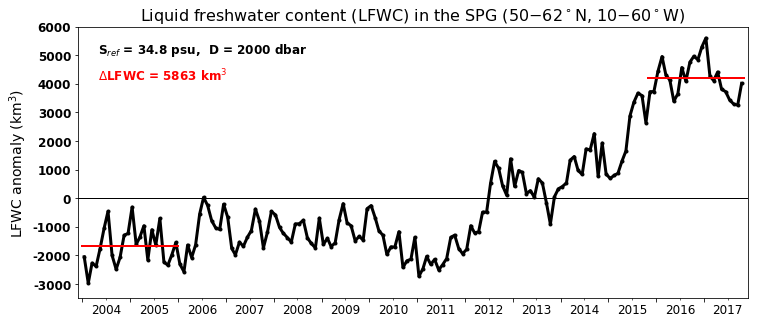